In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import umap

import pandas as pd
from scipy.spatial import cKDTree

In [5]:
df = pd.read_csv('../../dataset/m_test.csv')

print(df.columns.values)

['object_id' 'photoz' 'petroR90_r' 'r_cmodel_mag_ge' 'g_cmodel_mag_ge'
 'i_cmodel_mag_ge' 'z_cmodel_mag_ge' 'image_path' 'petro_half_light'
 'petro_90_light' 'dataset' 'snapshot_id' 'subhalo_id'
 'root_descendant_id' 'lookback' 'z' 'stellar_age_2rhalf_lumw'
 'fraction_disk_stars' 'stellar_mass' 'mass_in_rad' 'mass_exsitu'
 'half_mass_rad_physical' 'snap_num_last_maj_merger'
 'mass_last_maj_merger' 'mean_merger_lookback_time'
 'mean_merger_mass_ratio' 'color' 'i_band_mag_dust_apparent' 'mass'
 'lookback_time_last_maj_merger' 'exsitu']


In [6]:
import pandas as pd
from sklearn.utils import shuffle

#Set seed
SEED = 0

#Plot a single UMAP of x with color c
def create_umap(x, n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean'):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        densmap=False,
        random_state=SEED
    )
    u = fit.fit_transform(x);
    
    return np.array(u)

with open('../../postprocessing/representation.npy', 'rb') as f:
    rep = np.load(f)
        

n_neighbors = [10, 50, 100]
min_dist = [0.1, 0.5, 1]

for n in n_neighbors:
    for dist in min_dist:
        try:
            u = create_umap(rep, n_neighbors=n, min_dist=dist)
            d = {'u_0': u[:,0], 'u_1': u[:,1], 'dataset': df['dataset']}
            plt.title('n_neighbors = ' + str(n) + ' ' + 'min_dist = ' + str(dist))
            sns.kdeplot(data=pd.DataFrame(d), x='u_0', y='u_1', hue="dataset")
            plt.show()
        except:
            print('n_neighbors = ' + str(n) + ' ' + 'min_dist = ' + str(dist) + ' failed!')

In [7]:
u = create_umap(rep, n_neighbors=100, min_dist=0.5)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


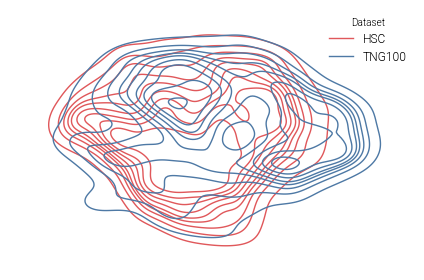

In [8]:
dataset = df['dataset'].to_numpy()
dataset[dataset=='HSC_TNG100'] = 'TNG100' 
d = {'u_0': u[:,0], 'u_1': u[:,1], 'Dataset': dataset}
g = sns.kdeplot(data=pd.DataFrame(d), x='u_0', y='u_1', hue="Dataset")
ax = plt.gca()
ax.axis('off')
g.get_figure().savefig("../../temp/kde.pdf") 
plt.show()

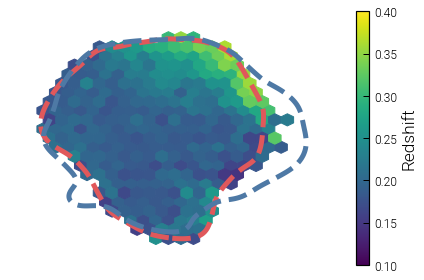

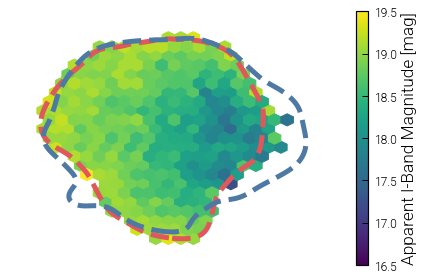

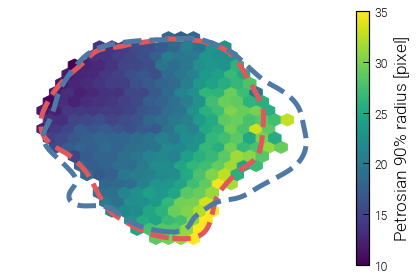

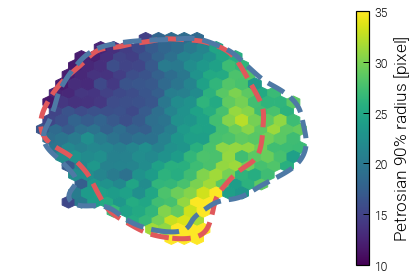

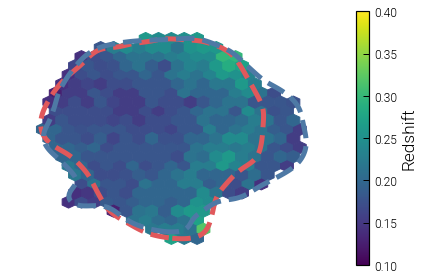

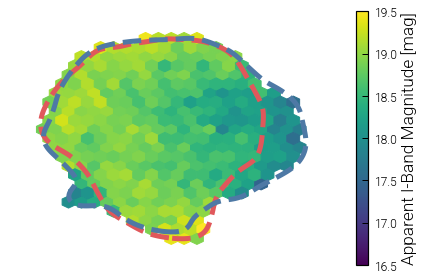

In [9]:
dataset = df['dataset']
TNG_mask = dataset == 'TNG100'
HSC_mask = dataset == 'HSC'

vmin = [0.1,16.5,10,10,0.1,16.5]
vmax = [0.4,19.5,35,35,0.4,19.5]
dataset = ['HSC','HSC','HSC','TNG','TNG','TNG']
masks = [HSC_mask,HSC_mask,HSC_mask,TNG_mask,TNG_mask,TNG_mask]
label_both = ['photoz', 'i_cmodel_mag_ge', 'petro_90_light', 'petro_90_light', 'z','i_band_mag_dust_apparent']
label_both_human = ['Redshift', 'Apparent I-Band Magnitude [mag]', 'Petrosian $90 \%$ radius [pixel]', 'Petrosian $90 \%$ radius [pixel]', 'Redshift','Apparent I-Band Magnitude [mag]']

for label, label_h, mask, d, mi, ma in zip(label_both, label_both_human, masks, dataset, vmin, vmax):
    plt.hexbin(u[mask,0],u[mask,1],
               C=df[label][mask],
               gridsize=20,
               mincnt=5,
               reduce_C_function=np.median,
               vmin = mi, 
               vmax = ma)
    
    sns.kdeplot(x=u[HSC_mask,0], y=u[HSC_mask,1], levels=1, linewidths=5, linestyles='dashed')
    sns.kdeplot(x=u[TNG_mask,0], y=u[TNG_mask,1], levels=1, linewidths=5, linestyles='dashed')
    plt.colorbar(label=label_h)
    ax = plt.gca()
    ax.axis('off')
    plt.savefig('../../temp/' + d + '_' + label + '.pdf')
    plt.show()
        

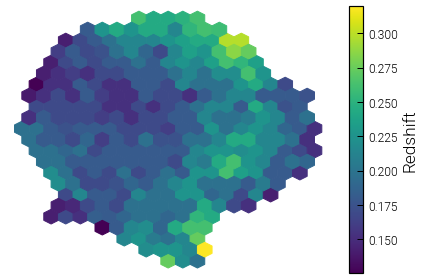

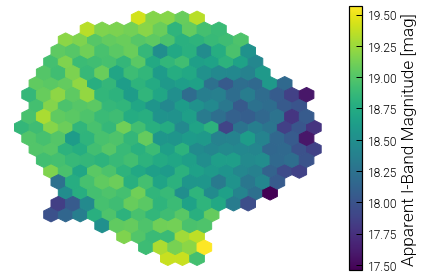

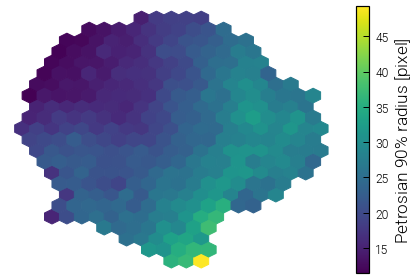

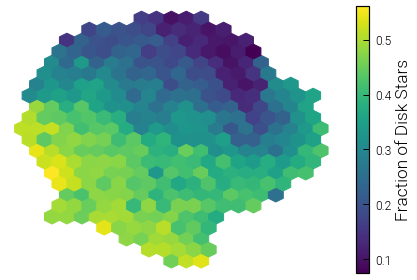

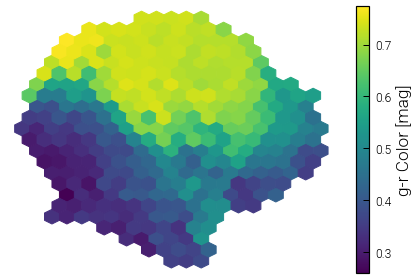

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


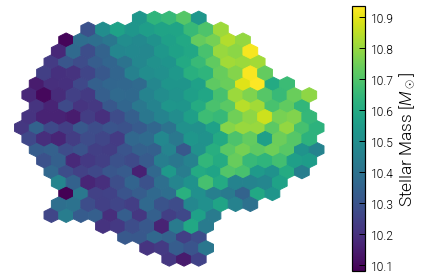

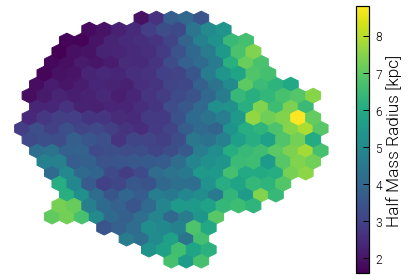

In [10]:
label_TNG =['z', 'i_band_mag_dust_apparent', 'petro_90_light', 'fraction_disk_stars', 'color',  'mass', 'half_mass_rad_physical']
label_TNG_human =['Redshift', 'Apparent I-Band Magnitude [mag]', 'Petrosian $90 \%$ radius [pixel]', 'Fraction of Disk Stars', 'g-r Color [mag]', 'Stellar Mass [$M_\odot$]', 'Half Mass Radius [kpc]']

for label, label_h in zip(label_TNG, label_TNG_human):
    plt.hexbin(u[TNG_mask,0],u[TNG_mask,1],C=df[label][TNG_mask], gridsize=20, mincnt=5, reduce_C_function=np.median)
    plt.colorbar(label=label_h)
    ax = plt.gca()
    ax.axis('off')
    plt.savefig('../../temp/' + label + '.pdf')
    plt.show()

In [11]:
NUM_IMAGES_PER_SIDE = 24

u0 = np.linspace(np.min(u[:,0]), np.max(u[:,0]), num=NUM_IMAGES_PER_SIDE)
u1 = np.linspace(np.min(u[:,1]), np.max(u[:,1]), num=NUM_IMAGES_PER_SIDE)

u0v, u1v = np.meshgrid(u0, u1)
#print(u0v)
#print(u1v)

In [12]:
def get_filenames(mask):
    tree = cKDTree(u[mask,:], compact_nodes=False, balanced_tree=False)
    image_paths = df['image_path'][mask].to_numpy()

    filenames = np.empty_like(u0v, dtype=object)
    MAX_DISTANCE = 0.1

    for i in range(NUM_IMAGES_PER_SIDE):
        for j in range(NUM_IMAGES_PER_SIDE):
            distance, index = tree.query([u0v[i,j], u1v[i,j]], k=[1], p=1, workers=-1)

            if distance < MAX_DISTANCE:
                filenames[i,j] = "../." + image_paths[index][0]
            else:
                filenames[i,j] = ""
                
    return filenames
        
HSC_filenames = get_filenames(df['dataset'] == 'HSC')
TNG100_filenames = get_filenames(df['dataset'] == 'TNG100')

/u/leisert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


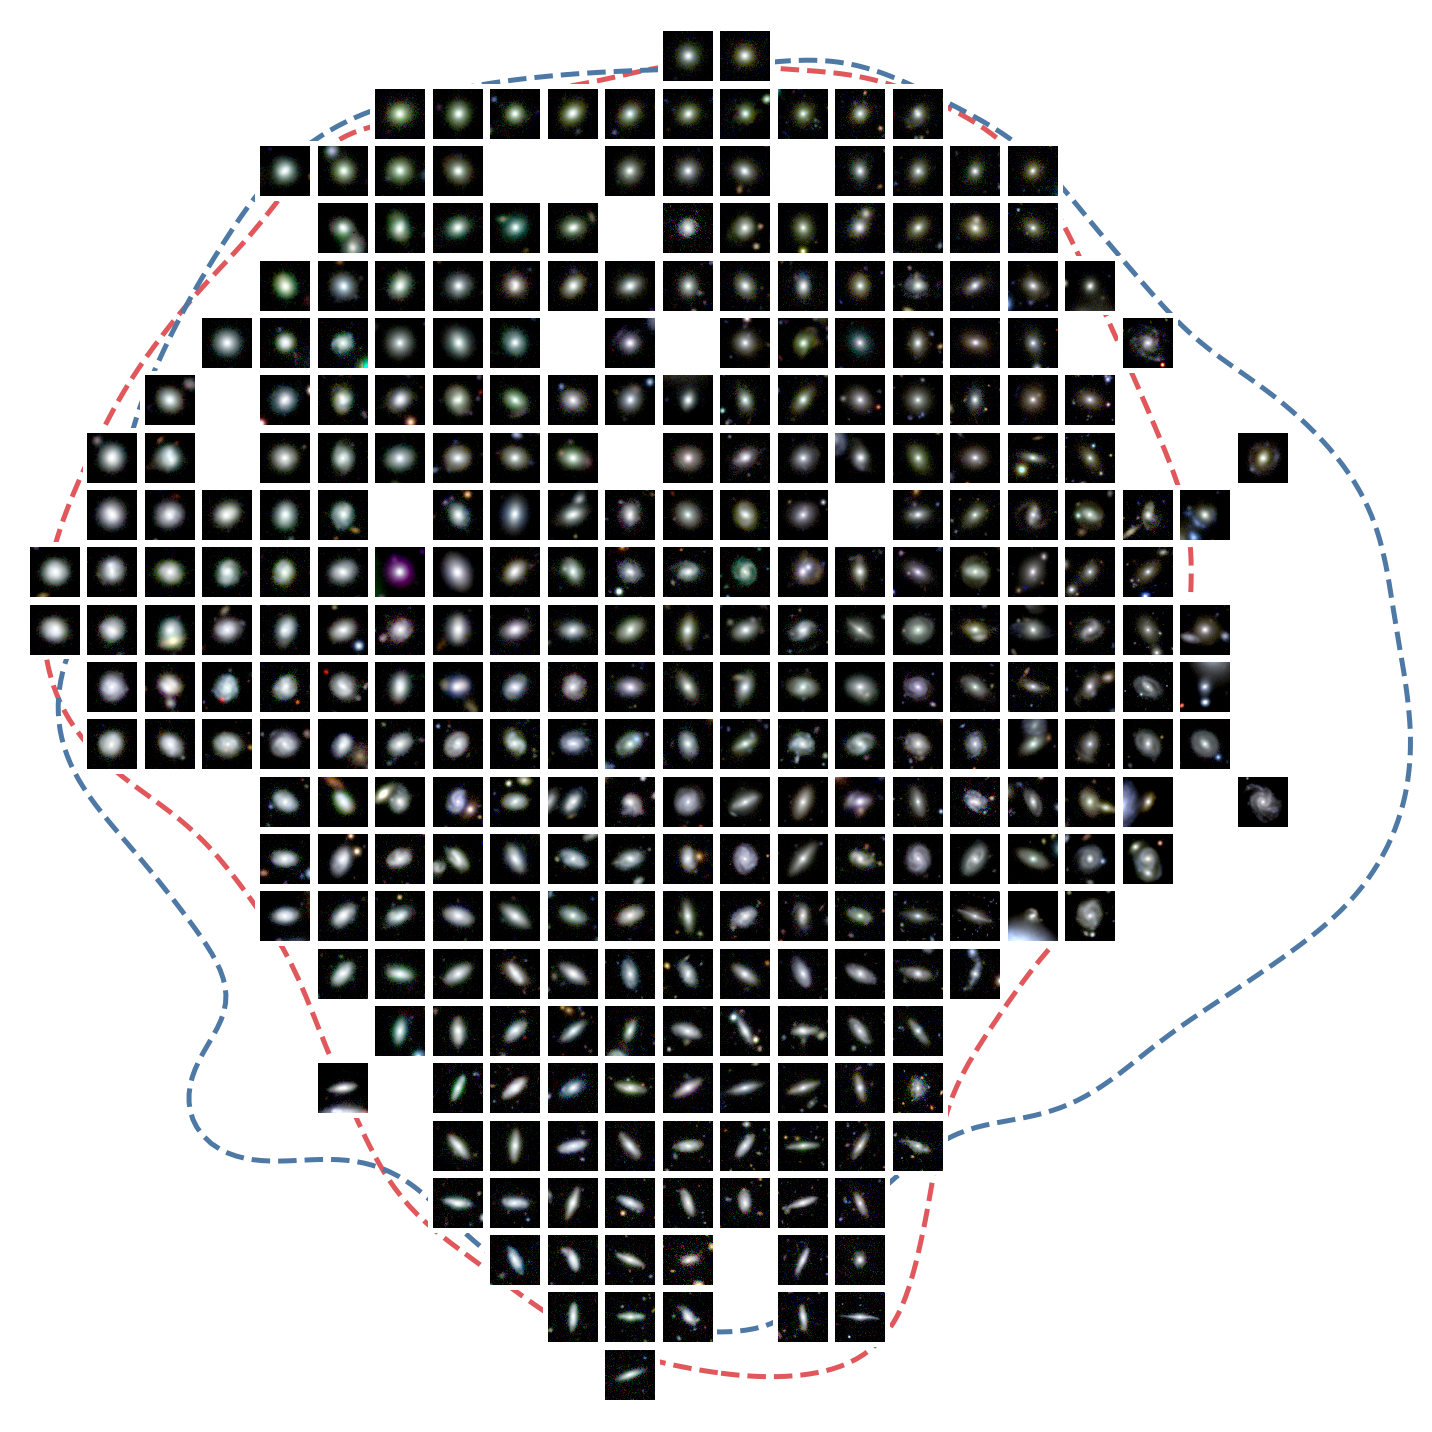

/u/leisert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


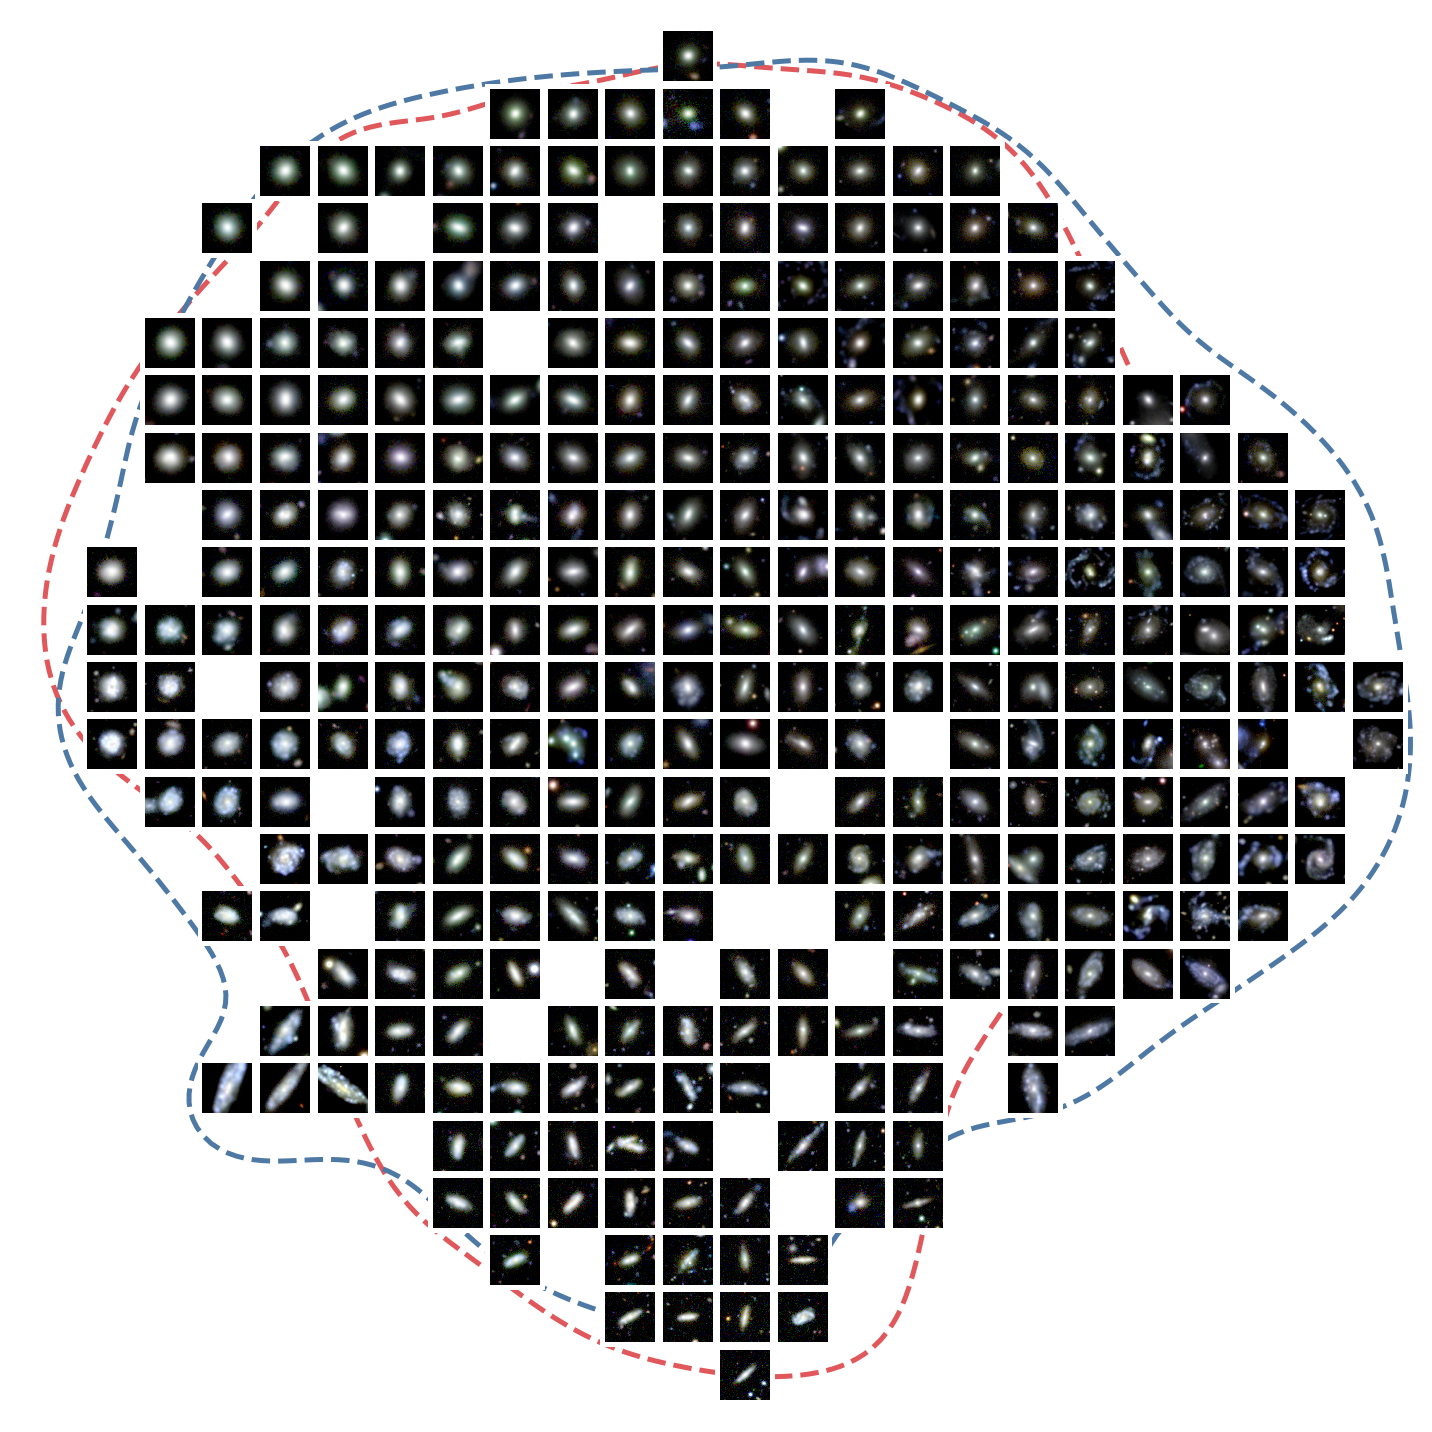

In [13]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import numpy as np
from astropy.io import fits

def load_image(filename):
    
    def get_central_crop(img, num_pixel=20):
        size = img.shape[0]
        center_coordinate = size//2
        upper = center_coordinate + num_pixel//2
        lower = center_coordinate - num_pixel//2
    
        return img[lower:upper, lower:upper]
    
    def stretch(x):
        x[x<=0] = np.nan
        x = np.log10(x)
        x[x<-7] = np.nan
        
        a_min = np.nanmedian(x)
        a_max = np.nanquantile(get_central_crop(x), 0.99)
        
        x = np.nan_to_num(x, nan=a_min, posinf=a_min, neginf=a_min)
        x = np.clip(x, a_min, a_max)
        
        x -= a_min
        x /= (a_max - a_min)
        
        return np.array(x*(2**8 - 1), dtype=np.uint8)
    
    with fits.open(filename) as hdul:
            
        G = hdul['G'].data
        R = hdul['R'].data
        I = hdul['I'].data
            
    G = stretch(G)
    R = stretch(R)
    I = stretch(I)

    return np.concatenate((I[...,np.newaxis],R[...,np.newaxis],G[...,np.newaxis]),axis=2)


for filenames, title in zip([HSC_filenames, TNG100_filenames], ("HSC", "TNG100")):
    
    fig, ax = plt.subplots(figsize=(20., 20.))

    PADDING = 0.5
    ax.set_xlim(u0[0]-PADDING, u0[-1]+PADDING)
    ax.set_ylim(u1[0]-PADDING, u1[-1]+PADDING)
    
    for i in range(NUM_IMAGES_PER_SIDE):
        for j in range(NUM_IMAGES_PER_SIDE):
            u0d = u0v[i,j]
            u1d = u1v[i,j]
            filename = filenames[i,j]

            if filename != "":
                im = load_image(filename)
                TARGET_IMAGE_SIZE = 50
                zoom_factor = TARGET_IMAGE_SIZE/im.shape[0]

                imagebox = OffsetImage(im, zoom=zoom_factor)
                ab = AnnotationBbox(imagebox, (u0d, u1d))
                ax.add_artist(ab)
                ax.axis('off')
                
    sns.kdeplot(x=u[HSC_mask,0], y=u[HSC_mask,1], levels=1, linewidths=5, linestyles='dashed')
    sns.kdeplot(x=u[TNG_mask,0], y=u[TNG_mask,1], levels=1, linewidths=5, linestyles='dashed')
    plt.savefig('../../temp/images_' + title + '.pdf')
    plt.show()